#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model10(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model10, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.Conv1dL = nn.Conv1d(self.max_len, 1, 1)
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1,0,2)
        out = self.Conv1dL(out).squeeze()
        out = self.DenseL2(out)
        return out
    

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 43.59batch/s, loss=0.177]


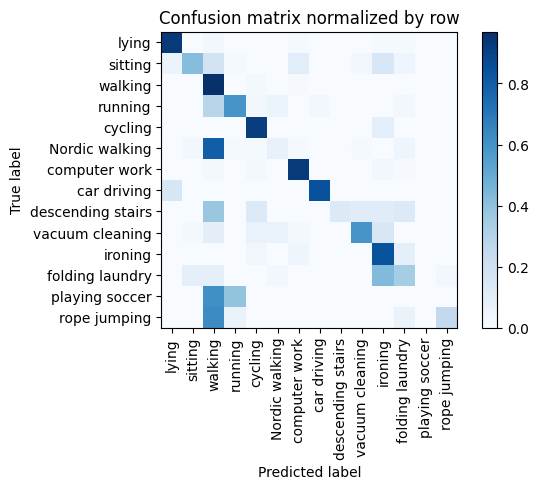

Training Epoch:  10%|█         | 1/10 [00:18<02:47, 18.62s/it]

Overall accuracy: 0.654



eval: 100%|██████████| 26/26 [00:00<00:00, 45.61batch/s, loss=0.126]


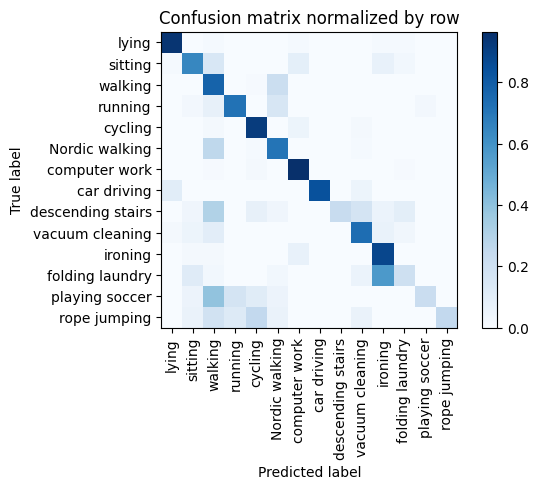

Training Epoch:  20%|██        | 2/10 [00:24<01:26, 10.87s/it]

Overall accuracy: 0.736



eval: 100%|██████████| 26/26 [00:00<00:00, 46.26batch/s, loss=0.207]


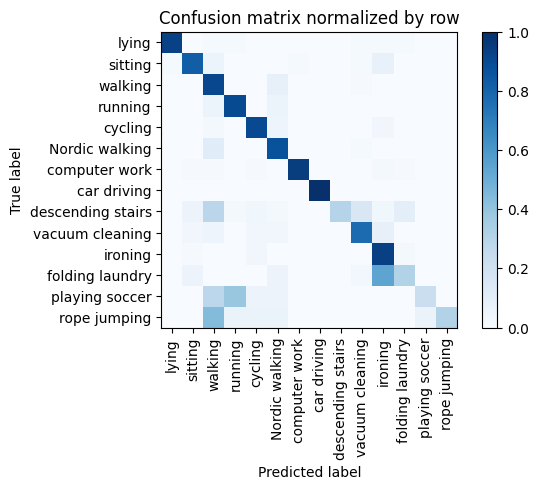

Training Epoch:  30%|███       | 3/10 [00:29<00:59,  8.51s/it]

Overall accuracy: 0.807



eval: 100%|██████████| 26/26 [00:00<00:00, 45.65batch/s, loss=0.167]


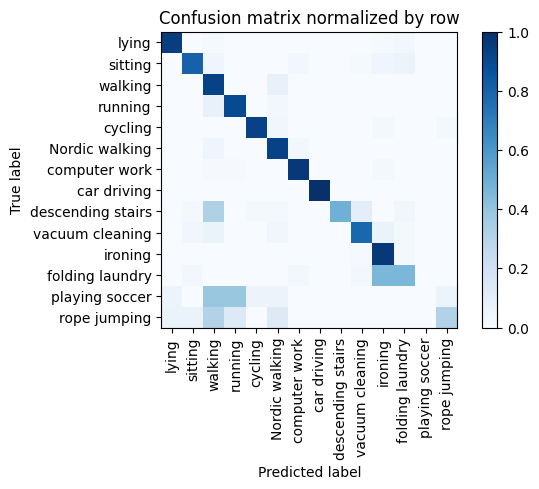

Training Epoch:  40%|████      | 4/10 [00:35<00:44,  7.40s/it]

Overall accuracy: 0.838



eval: 100%|██████████| 26/26 [00:00<00:00, 44.90batch/s, loss=0.115]


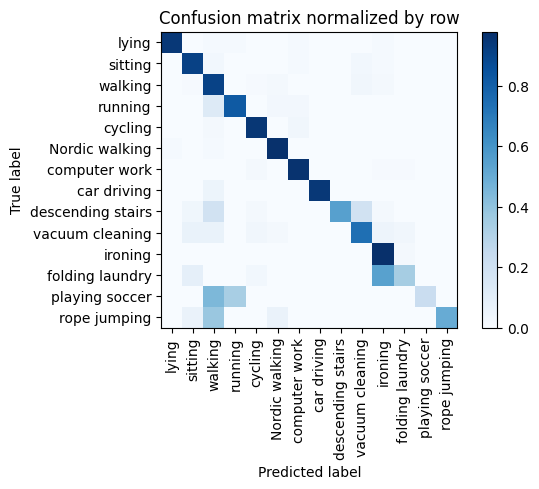

Training Epoch:  50%|█████     | 5/10 [00:41<00:34,  6.83s/it]

Overall accuracy: 0.849



eval: 100%|██████████| 26/26 [00:00<00:00, 41.20batch/s, loss=0.0851]


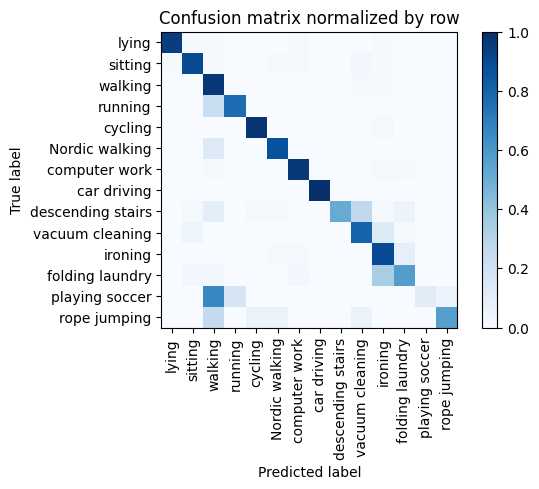

Training Epoch:  60%|██████    | 6/10 [00:47<00:25,  6.48s/it]

Overall accuracy: 0.849



eval: 100%|██████████| 26/26 [00:00<00:00, 57.02batch/s, loss=0.0998]


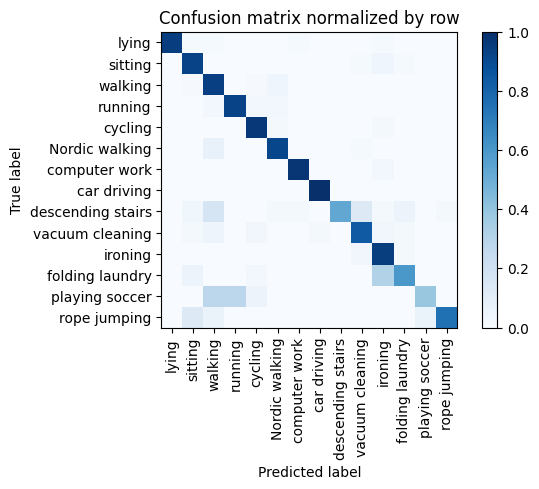

Training Epoch:  70%|███████   | 7/10 [00:52<00:18,  6.20s/it]

Overall accuracy: 0.880



eval: 100%|██████████| 26/26 [00:00<00:00, 46.76batch/s, loss=0.0955]


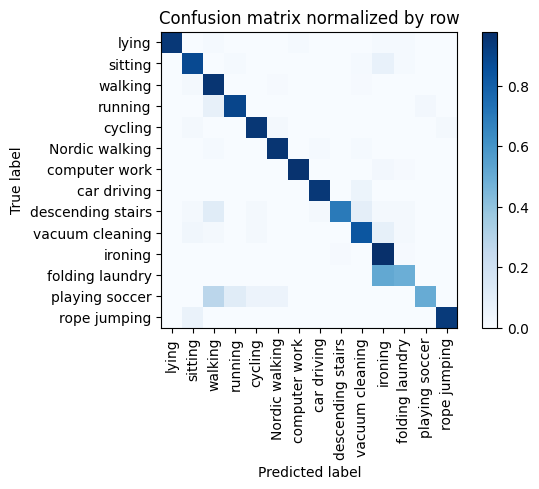

Training Epoch:  80%|████████  | 8/10 [00:58<00:11,  6.00s/it]

Overall accuracy: 0.893



eval: 100%|██████████| 26/26 [00:00<00:00, 46.51batch/s, loss=0.0623]


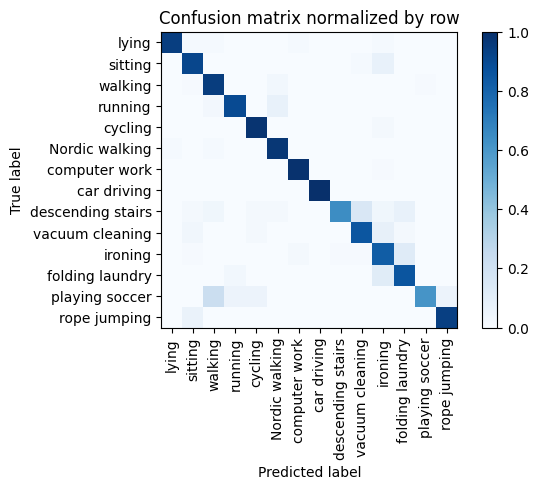

Training Epoch:  90%|█████████ | 9/10 [01:04<00:05,  5.96s/it]

Overall accuracy: 0.902



eval: 100%|██████████| 26/26 [00:00<00:00, 44.40batch/s, loss=0.0333]


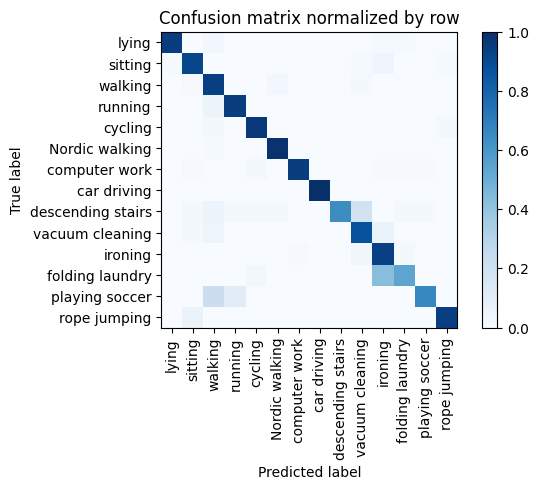

Overall accuracy: 0.898



eval: 100%|██████████| 28/28 [00:00<00:00, 51.61batch/s, loss=0.427]


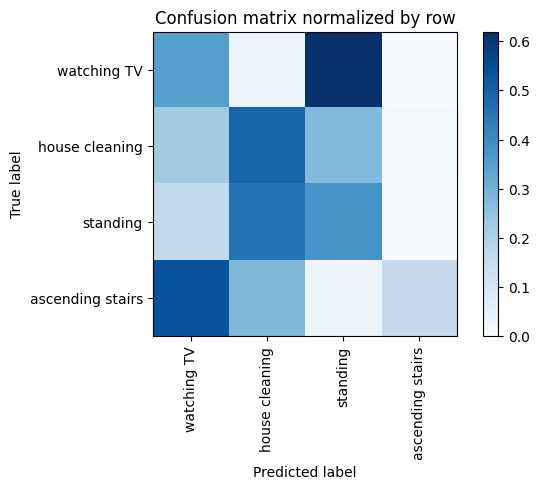

Overall accuracy: 0.366

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.408      0.376      0.392      0.337        295|	 house cleaning: 0.458,	watching TV: 0.163,	
  house cleaning       0.426      0.491      0.456      0.323        283|	 standing: 0.276,	watching TV: 0.223,	
ascending stairs       0.871      0.157      0.266      0.196        172|	 watching TV: 0.535,	house cleaning: 0.279,	
     watching TV       0.178      0.349      0.236      0.144        126|	 standing: 0.619,	house cleaning: 0.032,	

----------------------------------------------------------------------------------------------------
     avg / total       0.472      0.366      0.365        1.0        876|	      

{'total_accuracy': 0.3664383561643836, 'precision': 0.47089349928740587, 'recall': 0.34340508939289743, 'f1': 0.3374888048549878}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'desc

eval: 100%|██████████| 26/26 [00:00<00:00, 43.30batch/s, loss=0.232]


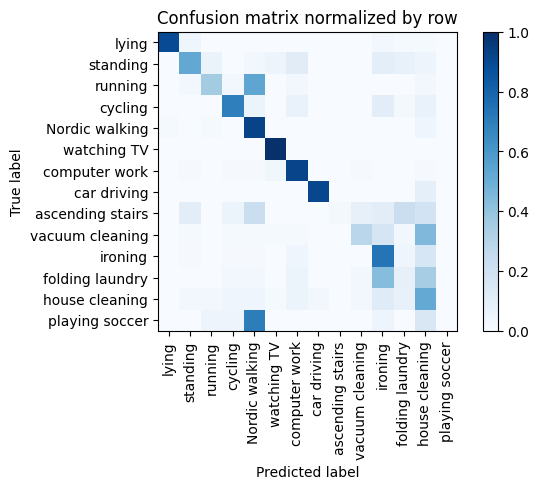

Training Epoch:  10%|█         | 1/10 [00:06<00:55,  6.18s/it]

Overall accuracy: 0.612



eval: 100%|██████████| 26/26 [00:00<00:00, 46.18batch/s, loss=0.151]


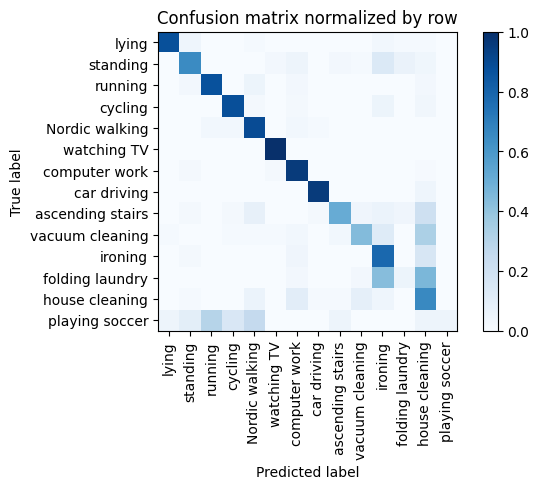

Training Epoch:  20%|██        | 2/10 [00:12<00:47,  5.98s/it]

Overall accuracy: 0.724



eval: 100%|██████████| 26/26 [00:00<00:00, 44.75batch/s, loss=0.149]


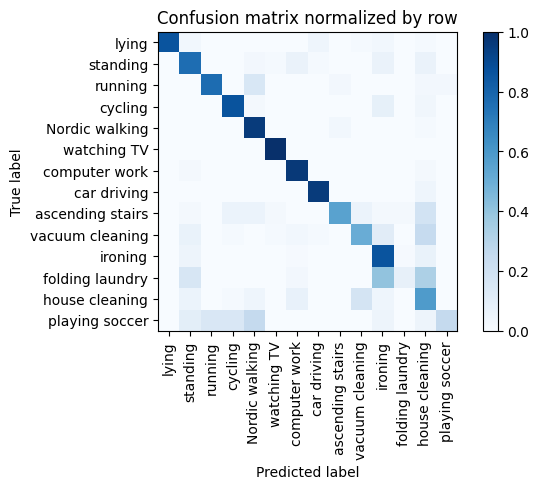

Training Epoch:  30%|███       | 3/10 [00:17<00:41,  5.93s/it]

Overall accuracy: 0.752



eval: 100%|██████████| 26/26 [00:00<00:00, 44.75batch/s, loss=0.108]


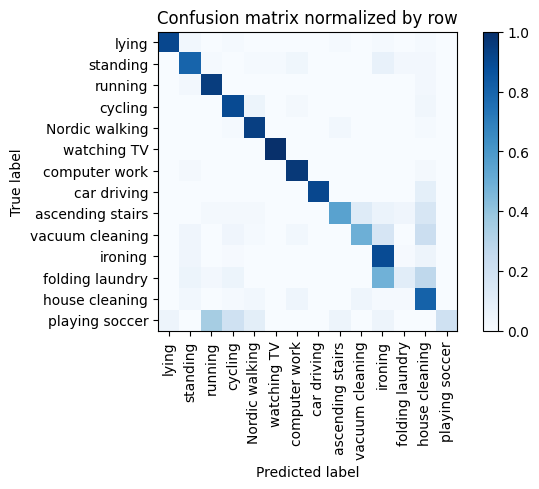

Training Epoch:  40%|████      | 4/10 [00:23<00:35,  5.86s/it]

Overall accuracy: 0.789



eval: 100%|██████████| 26/26 [00:00<00:00, 44.83batch/s, loss=0.103]


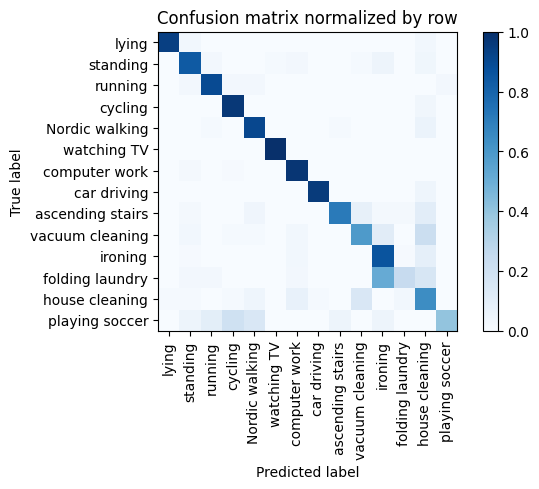

Training Epoch:  50%|█████     | 5/10 [00:29<00:29,  5.85s/it]

Overall accuracy: 0.810



eval: 100%|██████████| 26/26 [00:00<00:00, 37.04batch/s, loss=0.0636]


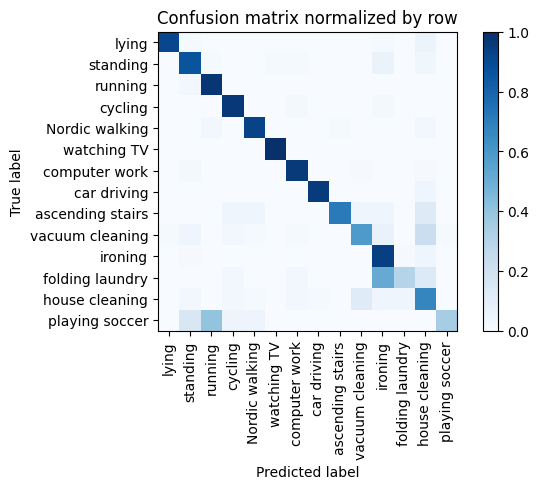

Training Epoch:  60%|██████    | 6/10 [00:35<00:23,  5.91s/it]

Overall accuracy: 0.827



eval: 100%|██████████| 26/26 [00:00<00:00, 52.26batch/s, loss=0.149]


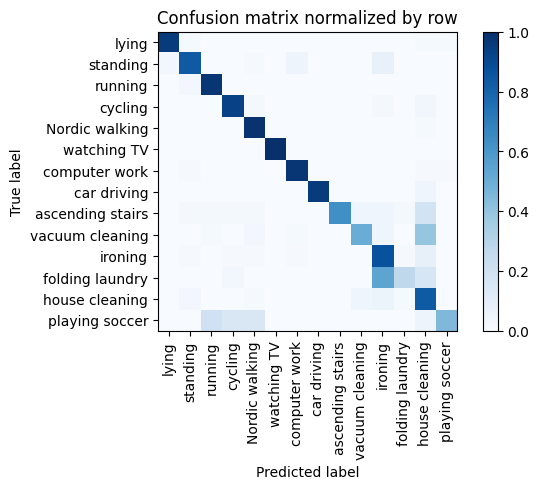

Training Epoch:  70%|███████   | 7/10 [00:41<00:17,  5.95s/it]

Overall accuracy: 0.826



eval: 100%|██████████| 26/26 [00:00<00:00, 43.41batch/s, loss=0.0826]


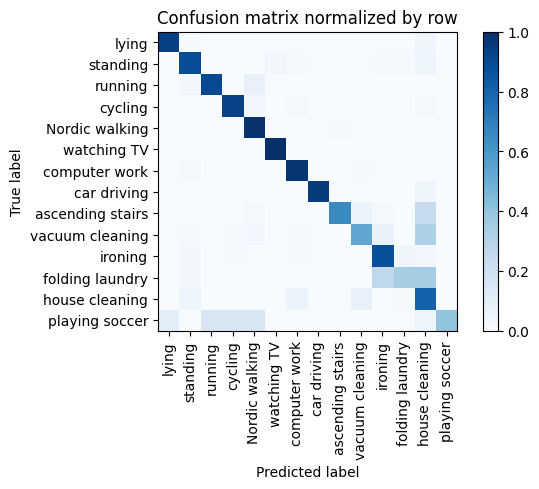

Training Epoch:  80%|████████  | 8/10 [00:47<00:11,  5.86s/it]

Overall accuracy: 0.831



eval: 100%|██████████| 26/26 [00:00<00:00, 41.53batch/s, loss=0.128]


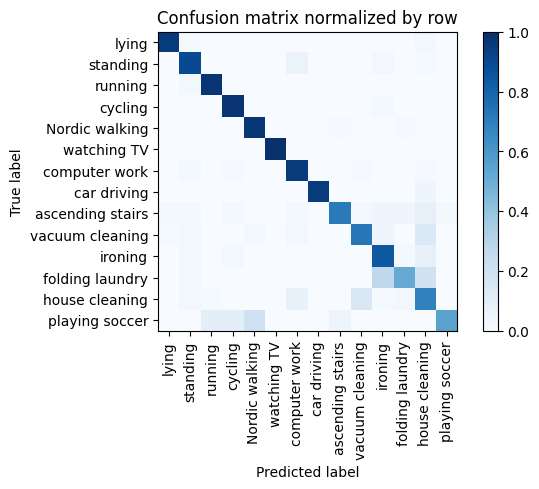

Training Epoch:  90%|█████████ | 9/10 [00:53<00:06,  6.07s/it]

Overall accuracy: 0.854



eval: 100%|██████████| 26/26 [00:00<00:00, 42.62batch/s, loss=0.127]


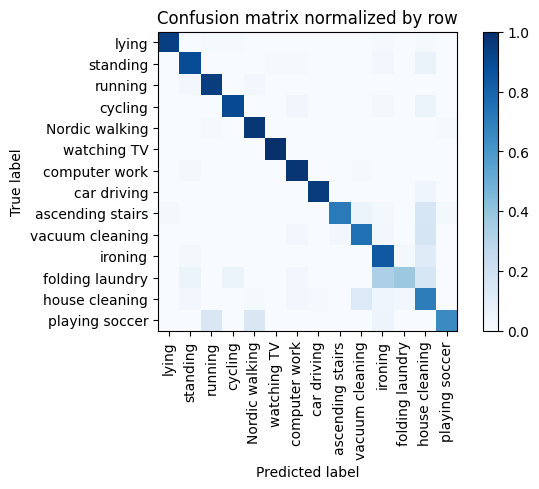

Overall accuracy: 0.847



eval: 100%|██████████| 28/28 [00:00<00:00, 58.82batch/s, loss=0.346]


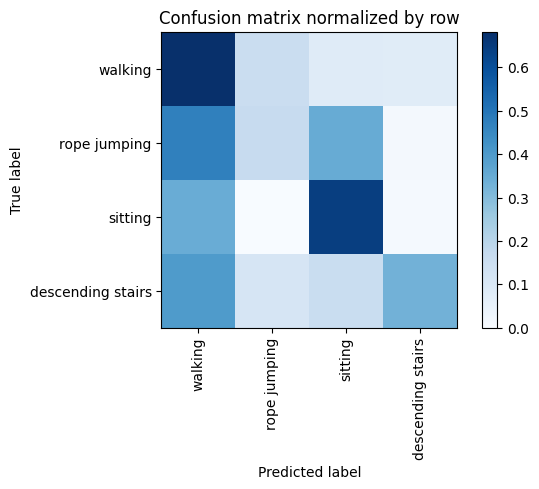

Overall accuracy: 0.567

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.565      0.682      0.618      0.418        365|	 rope jumping: 0.156,	sitting: 0.082,	
          sitting       0.701      0.644      0.672      0.325        284|	 walking: 0.345,	descending stairs: 0.011,	
descending stairs       0.612      0.329      0.428      0.181        158|	 walking: 0.399,	sitting: 0.158,	
     rope jumping       0.128      0.167      0.145      0.076         66|	 walking: 0.470,	sitting: 0.348,	

----------------------------------------------------------------------------------------------------
      avg / total       0.585      0.567      0.565        1.0        873|	      

{'total_accuracy': 0.5670103092783505, 'precision': 0.5013617395635078, 'recall': 0.455584642180579, 'f1': 0.4655365047975539}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work

eval: 100%|██████████| 24/24 [00:00<00:00, 46.51batch/s, loss=0.234]


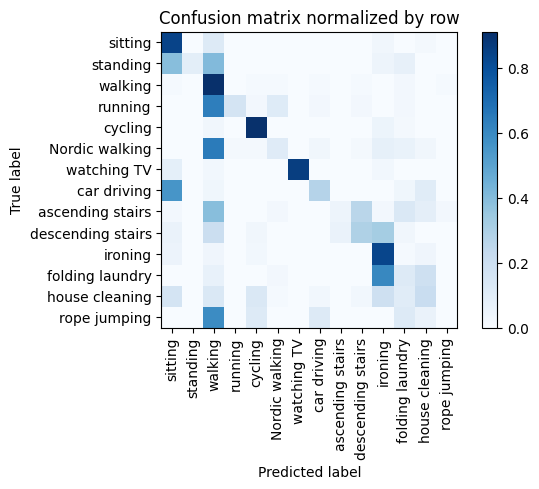

Training Epoch:  10%|█         | 1/10 [00:05<00:50,  5.65s/it]

Overall accuracy: 0.470



eval: 100%|██████████| 24/24 [00:00<00:00, 59.26batch/s, loss=0.179]


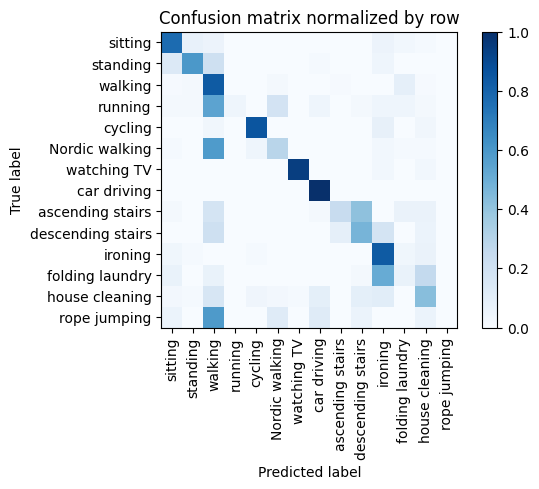

Training Epoch:  20%|██        | 2/10 [00:10<00:40,  5.06s/it]

Overall accuracy: 0.574



eval: 100%|██████████| 24/24 [00:00<00:00, 49.48batch/s, loss=0.149]


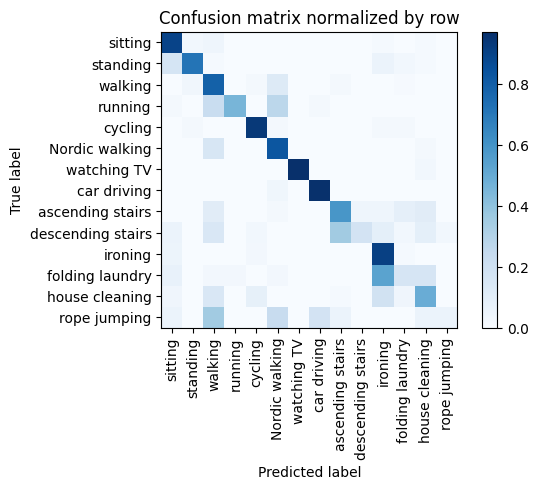

Training Epoch:  30%|███       | 3/10 [00:14<00:31,  4.55s/it]

Overall accuracy: 0.697



eval: 100%|██████████| 24/24 [00:00<00:00, 56.73batch/s, loss=0.156]


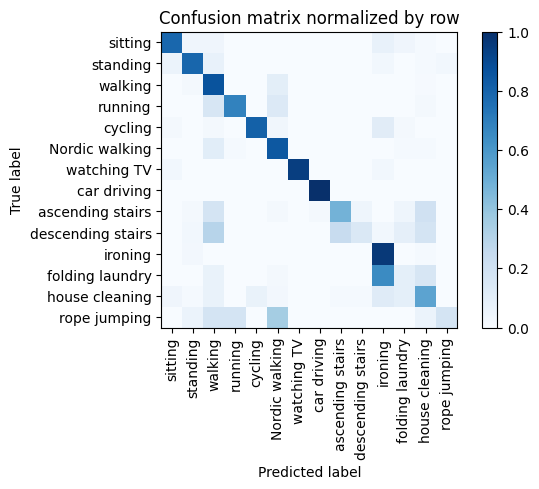

Training Epoch:  40%|████      | 4/10 [00:17<00:25,  4.23s/it]

Overall accuracy: 0.707



eval: 100%|██████████| 24/24 [00:00<00:00, 62.99batch/s, loss=0.0971]


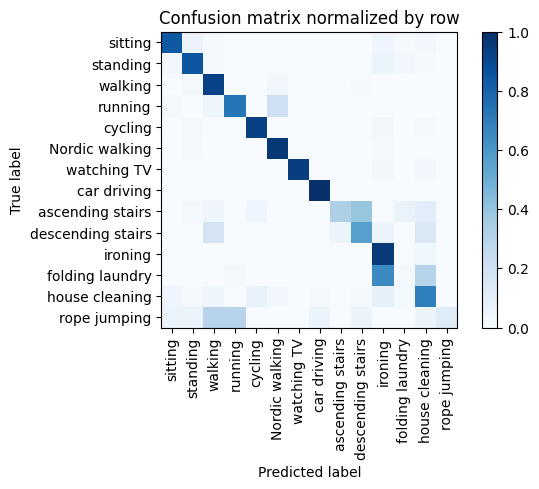

Training Epoch:  50%|█████     | 5/10 [00:21<00:20,  4.01s/it]

Overall accuracy: 0.768



eval: 100%|██████████| 24/24 [00:00<00:00, 55.43batch/s, loss=0.118]


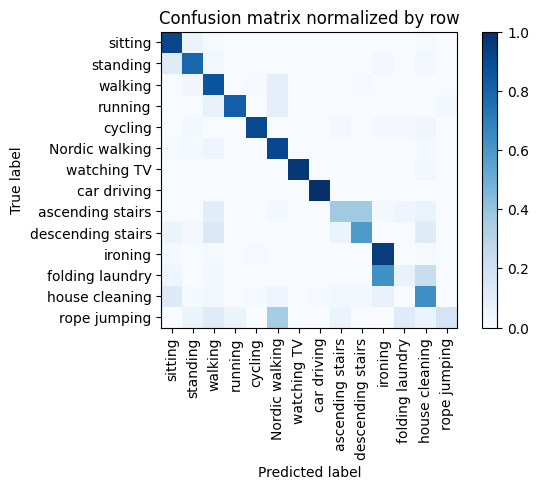

Training Epoch:  60%|██████    | 6/10 [00:25<00:16,  4.00s/it]

Overall accuracy: 0.760



eval: 100%|██████████| 24/24 [00:00<00:00, 65.74batch/s, loss=0.12]


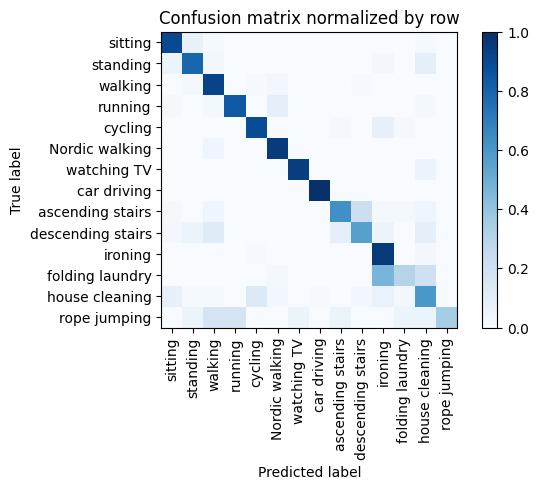

Training Epoch:  70%|███████   | 7/10 [00:29<00:11,  3.94s/it]

Overall accuracy: 0.798



eval: 100%|██████████| 24/24 [00:00<00:00, 62.83batch/s, loss=0.0785]


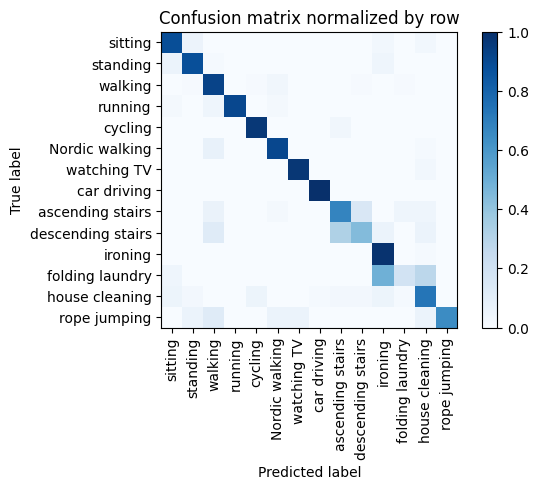

Training Epoch:  80%|████████  | 8/10 [00:33<00:07,  3.87s/it]

Overall accuracy: 0.826



eval: 100%|██████████| 24/24 [00:00<00:00, 59.77batch/s, loss=0.064]


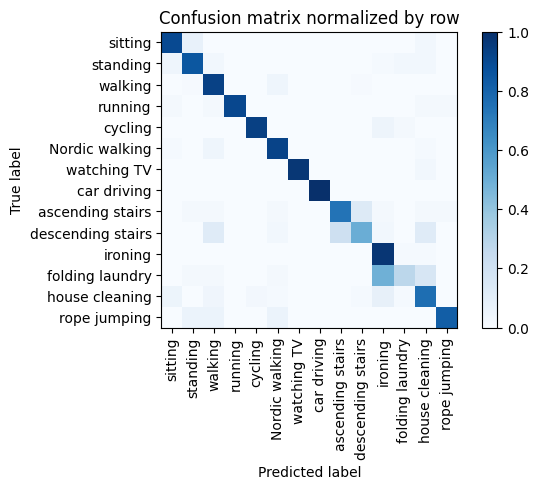

Training Epoch:  90%|█████████ | 9/10 [00:37<00:03,  3.94s/it]

Overall accuracy: 0.842



eval: 100%|██████████| 24/24 [00:00<00:00, 66.67batch/s, loss=0.0919]


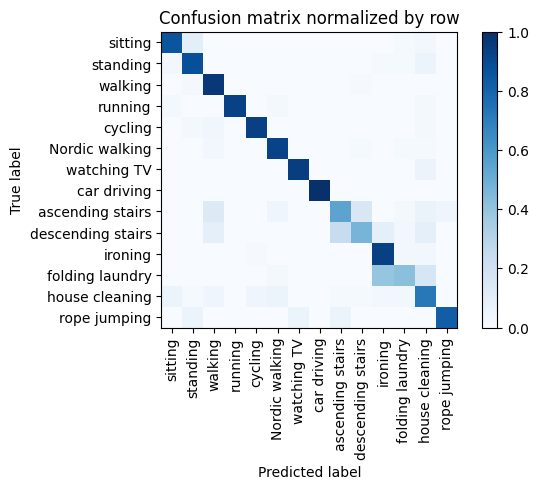

Overall accuracy: 0.831



eval: 100%|██████████| 35/35 [00:00<00:00, 80.83batch/s, loss=0.401]


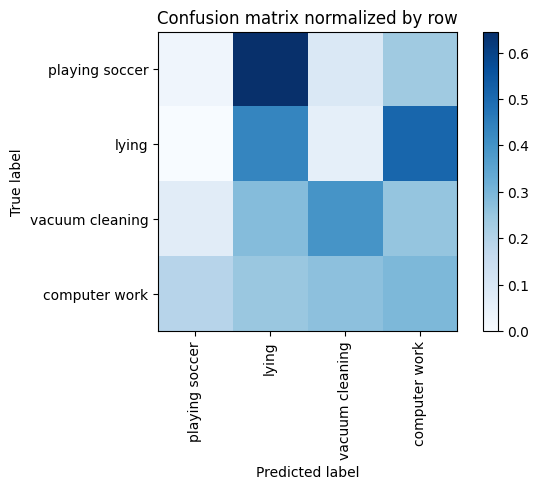

Overall accuracy: 0.336

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.367      0.293      0.326      0.424        468|	 vacuum cleaning: 0.269,	lying: 0.248,	
          lying       0.346      0.432      0.384      0.266        294|	 computer work: 0.510,	vacuum cleaning: 0.058,	
vacuum cleaning       0.412      0.393      0.402      0.242        267|	 lying: 0.281,	computer work: 0.255,	
 playing soccer       0.018      0.026      0.022      0.069         76|	 lying: 0.645,	computer work: 0.237,	vacuum cleaning: 0.092,	

----------------------------------------------------------------------------------------------------
    avg / total       0.348      0.336      0.339        1.0       1105|	      

{'total_accuracy': 0.3357466063348416, 'precision': 0.2858219488966923, 'recall': 0.28607051207266637, 'f1': 0.2834682765224325}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic wal

eval: 100%|██████████| 27/27 [00:00<00:00, 59.21batch/s, loss=0.175]


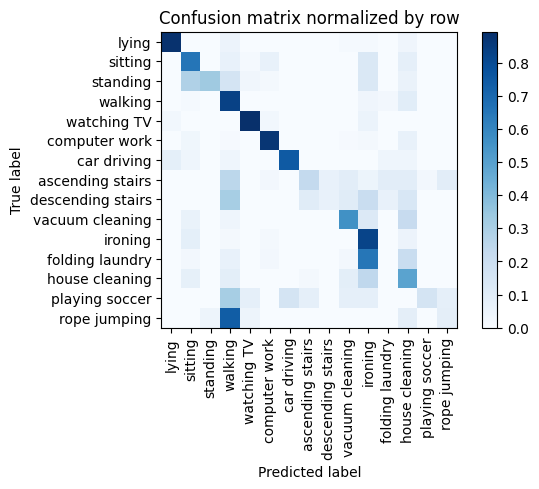

Training Epoch:  10%|█         | 1/10 [00:04<00:36,  4.05s/it]

Overall accuracy: 0.615



eval: 100%|██████████| 27/27 [00:00<00:00, 62.50batch/s, loss=0.116]


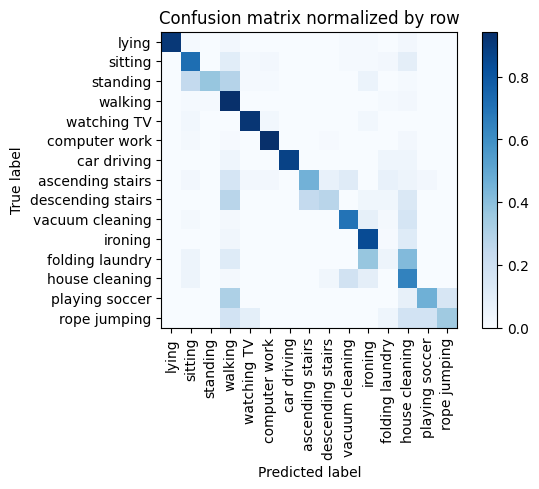

Training Epoch:  20%|██        | 2/10 [00:08<00:32,  4.10s/it]

Overall accuracy: 0.707



eval: 100%|██████████| 27/27 [00:00<00:00, 64.90batch/s, loss=0.124]


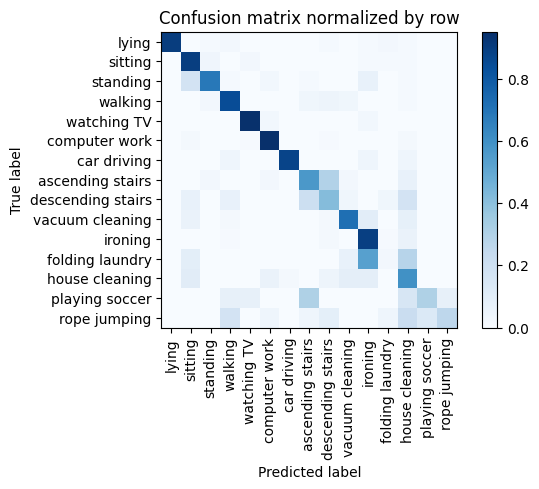

Training Epoch:  30%|███       | 3/10 [00:11<00:27,  3.97s/it]

Overall accuracy: 0.749



eval: 100%|██████████| 27/27 [00:00<00:00, 53.78batch/s, loss=0.0894]


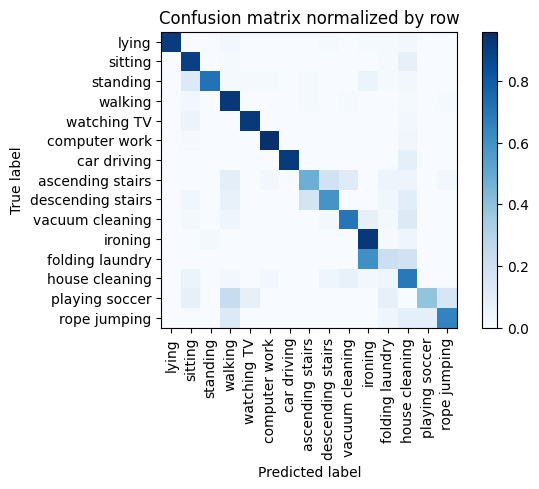

Training Epoch:  40%|████      | 4/10 [00:16<00:24,  4.08s/it]

Overall accuracy: 0.793



eval: 100%|██████████| 27/27 [00:00<00:00, 56.60batch/s, loss=0.0664]


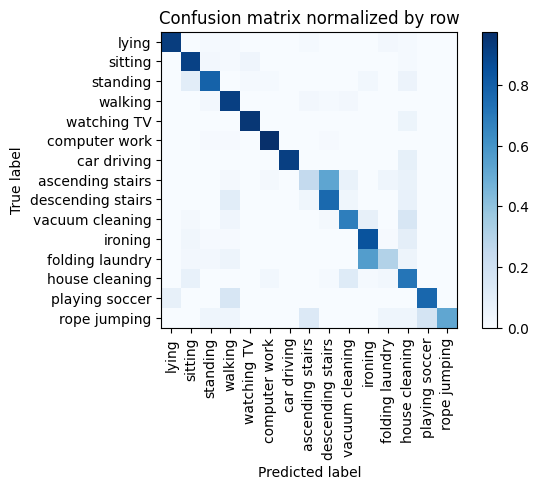

Training Epoch:  50%|█████     | 5/10 [00:20<00:20,  4.10s/it]

Overall accuracy: 0.796



eval: 100%|██████████| 27/27 [00:00<00:00, 54.77batch/s, loss=0.0765]


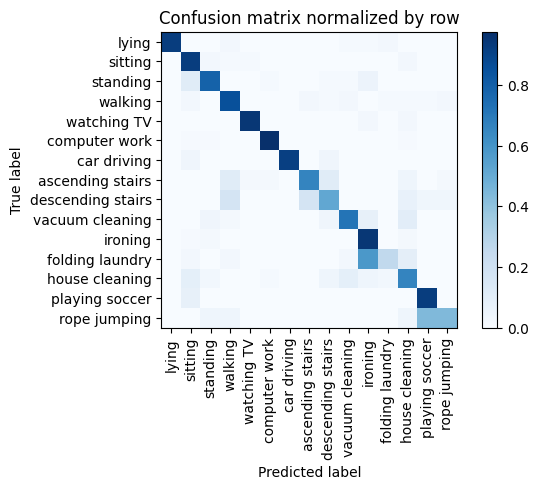

Training Epoch:  60%|██████    | 6/10 [00:24<00:16,  4.21s/it]

Overall accuracy: 0.811



eval: 100%|██████████| 27/27 [00:00<00:00, 49.82batch/s, loss=0.0446]


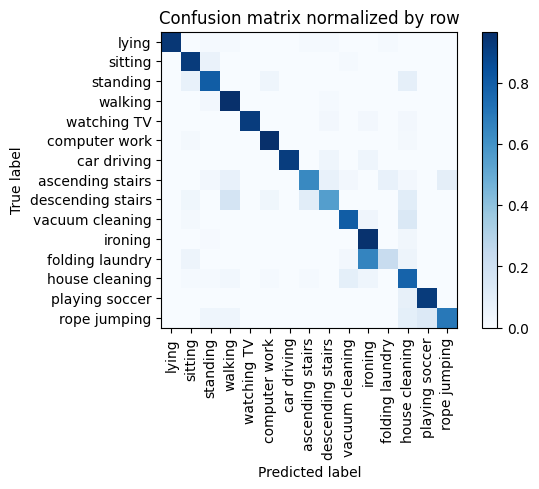

Training Epoch:  70%|███████   | 7/10 [00:30<00:14,  4.69s/it]

Overall accuracy: 0.842



eval: 100%|██████████| 27/27 [00:00<00:00, 67.07batch/s, loss=0.063]


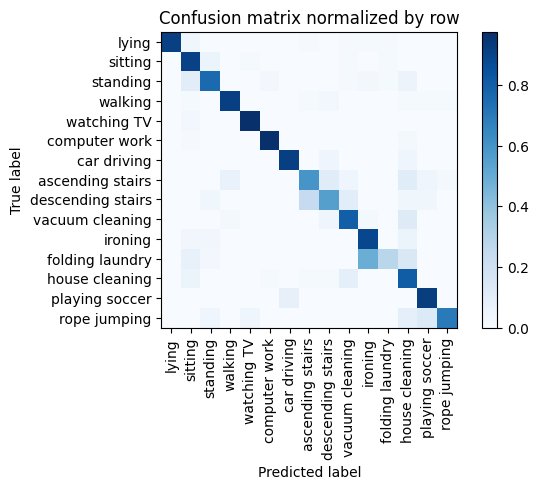

Training Epoch:  80%|████████  | 8/10 [00:34<00:09,  4.61s/it]

Overall accuracy: 0.829



eval: 100%|██████████| 27/27 [00:00<00:00, 65.81batch/s, loss=0.0723]


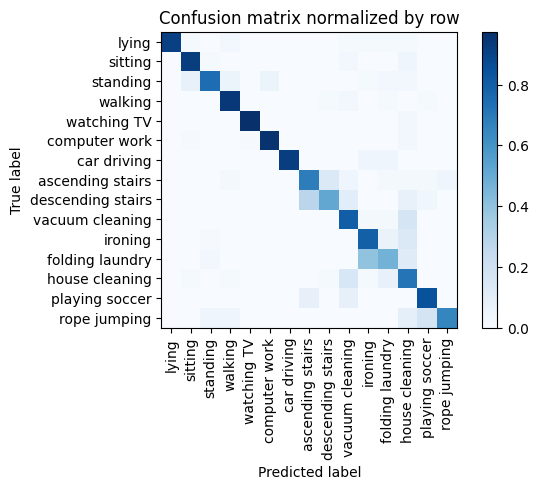

Training Epoch:  90%|█████████ | 9/10 [00:38<00:04,  4.34s/it]

Overall accuracy: 0.822



eval: 100%|██████████| 27/27 [00:00<00:00, 62.65batch/s, loss=0.0862]


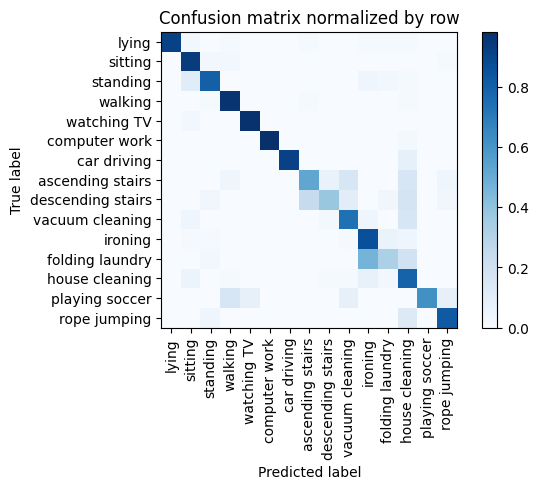

Overall accuracy: 0.825



eval: 100%|██████████| 22/22 [00:00<00:00, 70.97batch/s, loss=0.552]


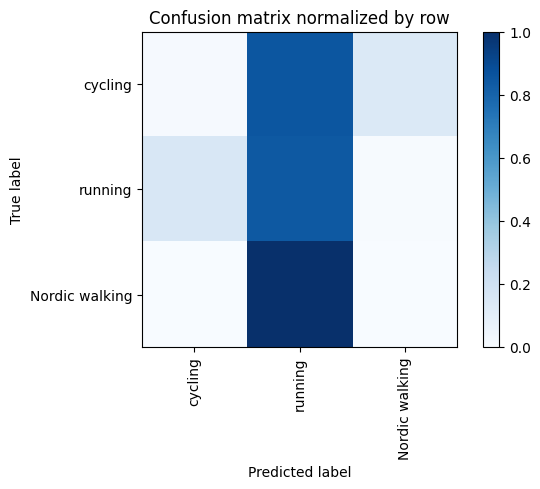

Overall accuracy: 0.187

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.420        288|	 running: 1.000,	cycling: 0.000,	
       cycling       0.080      0.008      0.015      0.361        247|	 running: 0.854,	Nordic walking: 0.138,	
       running       0.202      0.840      0.325      0.219        150|	 cycling: 0.153,	Nordic walking: 0.007,	

----------------------------------------------------------------------------------------------------
   avg / total       0.073      0.187      0.077        1.0        685|	      

{'total_accuracy': 0.18686131386861313, 'precision': 0.09386666666666667, 'recall': 0.2826990553306343, 'f1': 0.11328905755850728}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 66.99batch/s, loss=0.243]


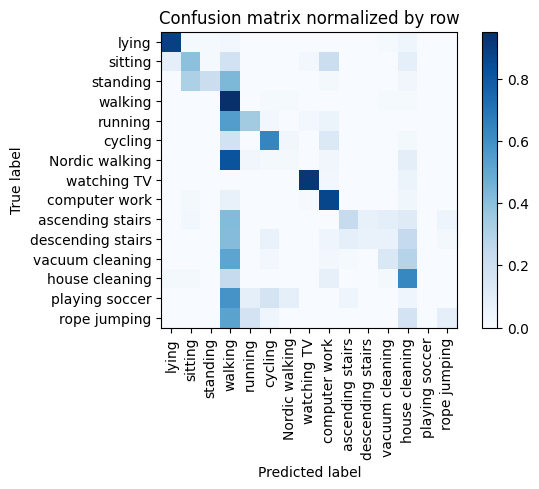

Training Epoch:  10%|█         | 1/10 [00:04<00:37,  4.15s/it]

Overall accuracy: 0.495



eval: 100%|██████████| 28/28 [00:00<00:00, 66.04batch/s, loss=0.14]


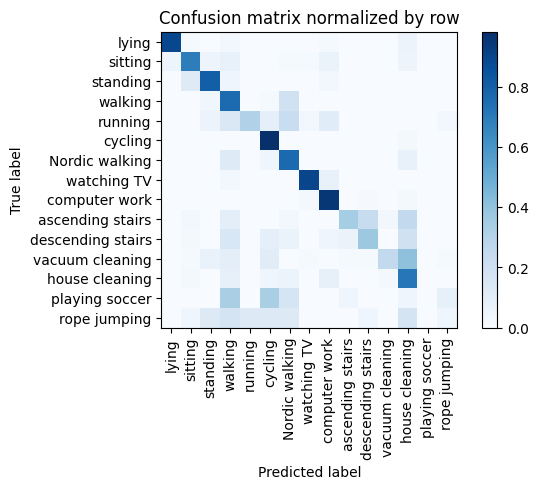

Training Epoch:  20%|██        | 2/10 [00:08<00:32,  4.06s/it]

Overall accuracy: 0.673



eval: 100%|██████████| 28/28 [00:00<00:00, 55.89batch/s, loss=0.135]


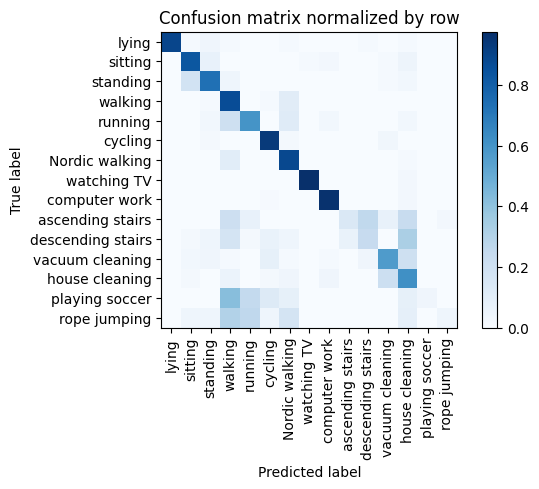

Training Epoch:  30%|███       | 3/10 [00:12<00:28,  4.11s/it]

Overall accuracy: 0.716



eval: 100%|██████████| 28/28 [00:00<00:00, 65.42batch/s, loss=0.0751]


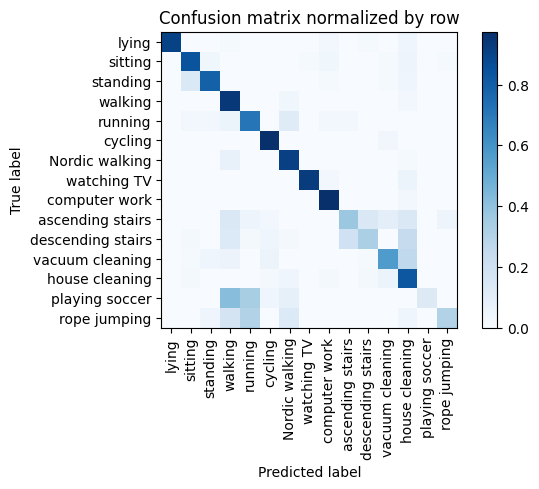

Training Epoch:  40%|████      | 4/10 [00:16<00:24,  4.09s/it]

Overall accuracy: 0.775



eval: 100%|██████████| 28/28 [00:00<00:00, 59.20batch/s, loss=0.138]


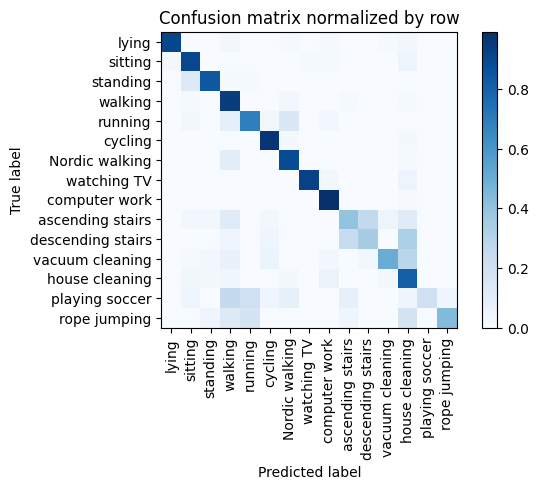

Training Epoch:  50%|█████     | 5/10 [00:20<00:20,  4.12s/it]

Overall accuracy: 0.784



eval: 100%|██████████| 28/28 [00:00<00:00, 60.09batch/s, loss=0.0988]


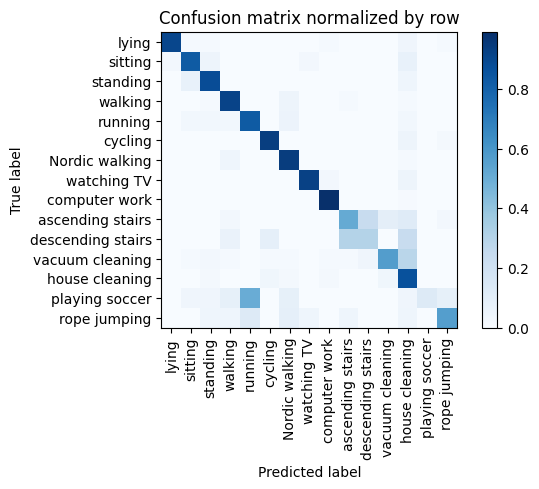

Training Epoch:  60%|██████    | 6/10 [00:24<00:16,  4.19s/it]

Overall accuracy: 0.800



eval: 100%|██████████| 28/28 [00:00<00:00, 60.21batch/s, loss=0.0698]


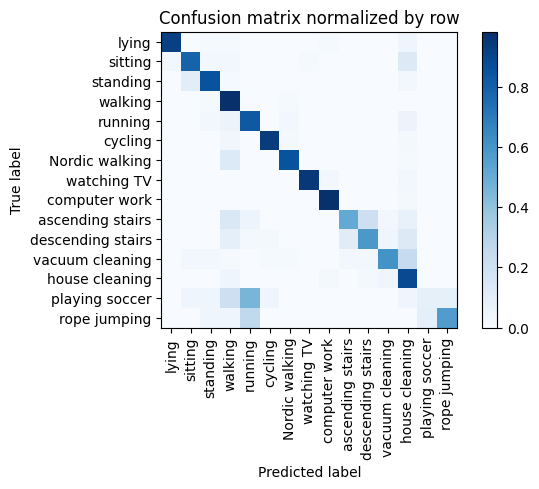

Training Epoch:  70%|███████   | 7/10 [00:28<00:12,  4.12s/it]

Overall accuracy: 0.812



eval: 100%|██████████| 28/28 [00:00<00:00, 63.64batch/s, loss=0.0996]


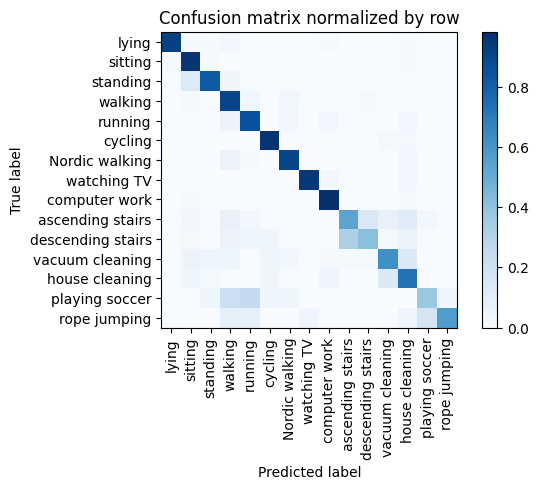

Training Epoch:  80%|████████  | 8/10 [00:32<00:08,  4.09s/it]

Overall accuracy: 0.818



eval: 100%|██████████| 28/28 [00:00<00:00, 67.31batch/s, loss=0.111]


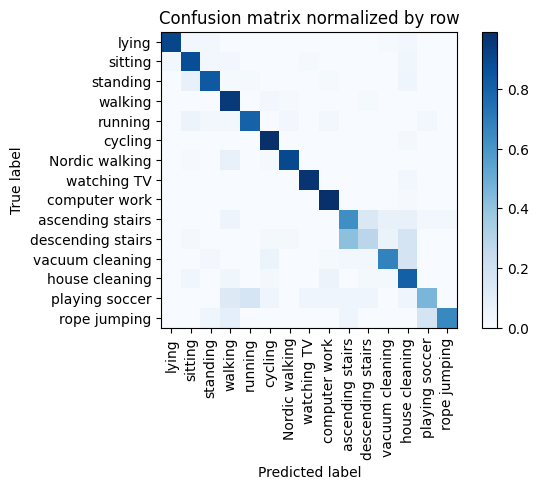

Training Epoch:  90%|█████████ | 9/10 [00:36<00:04,  4.05s/it]

Overall accuracy: 0.827



eval: 100%|██████████| 28/28 [00:00<00:00, 62.22batch/s, loss=0.0789]


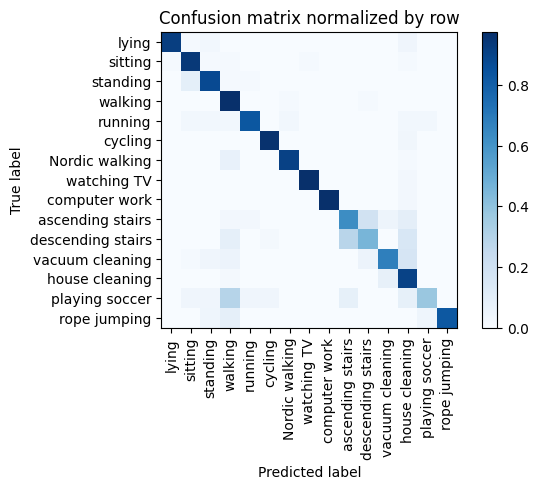

Overall accuracy: 0.855



eval: 100%|██████████| 19/19 [00:00<00:00, 57.06batch/s, loss=0.441]


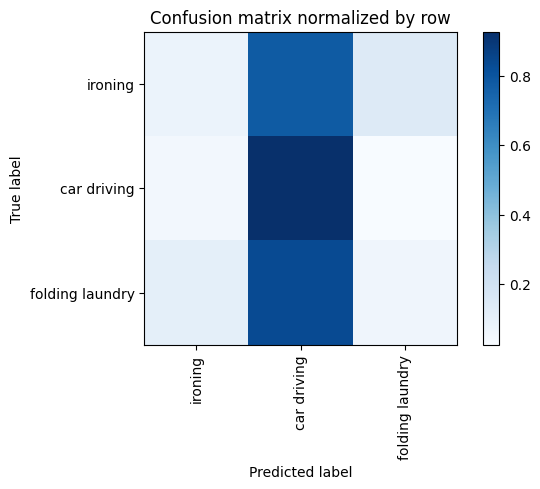

Overall accuracy: 0.194

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.592      0.080      0.141      0.606        363|	 car driving: 0.780,	folding laundry: 0.140,	
folding laundry       0.145      0.059      0.084      0.254        152|	 car driving: 0.836,	ironing: 0.105,	
    car driving       0.160      0.929      0.273      0.140         84|	 ironing: 0.048,	folding laundry: 0.024,	

----------------------------------------------------------------------------------------------------
    avg / total       0.418      0.194      0.145        1.0        599|	      

{'total_accuracy': 0.19365609348914858, 'precision': 0.2989446968634096, 'recall': 0.35589058734991746, 'f1': 0.16587204042970308}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.329943
precision         0.330178
recall            0.344730
f1                0.273131
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model10(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
        # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    